/tmp/ipython-input-3-2630432229.py:24: FutureWarning: Parsed string "Thu Jul 18 10:30:00 IST 2024" included an un-recognized timezone "IST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Date'] = pd.to_datetime(df['Date'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxkmph_3i/7z11mmqd.json


Saving output_file.csv to output_file (1).csv


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxkmph_3i/kbbgcsnv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99309', 'data', 'file=/tmp/tmpxkmph_3i/7z11mmqd.json', 'init=/tmp/tmpxkmph_3i/kbbgcsnv.json', 'output', 'file=/tmp/tmpxkmph_3i/prophet_modelk_v76zhl/prophet_model-20250708041057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:10:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


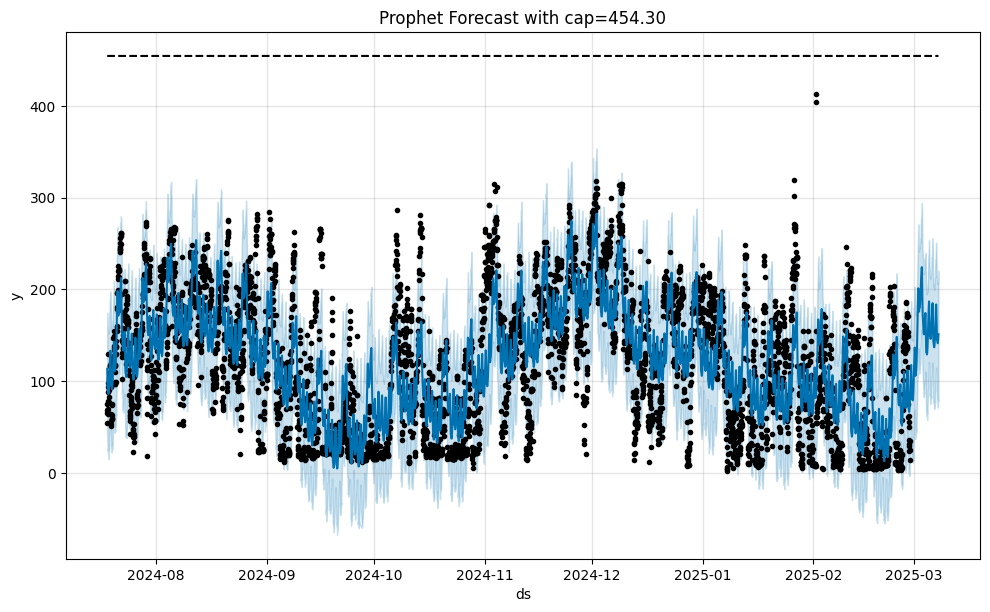

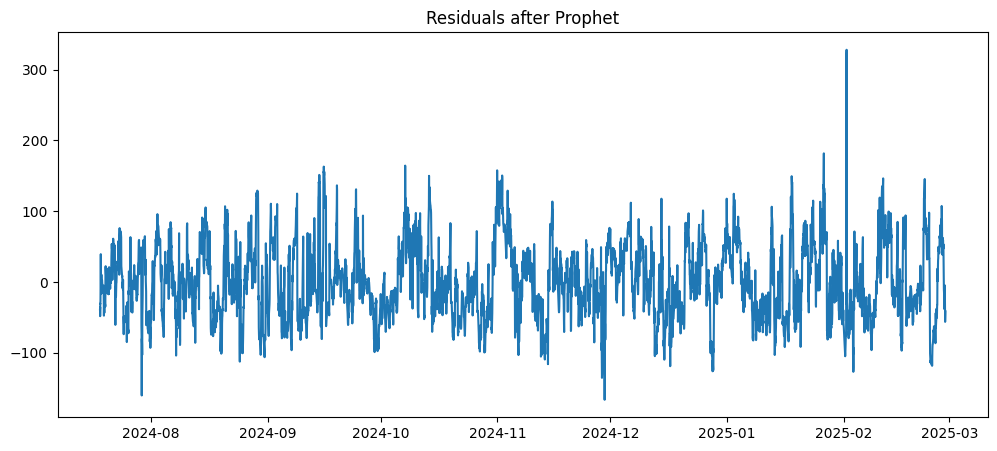

Epoch 1/50


/tmp/ipython-input-3-2630432229.py:72: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  residuals_hourly = residuals.resample('1H').mean().interpolate()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.5244 - val_loss: 0.2174
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.2463 - val_loss: 0.1468
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1865 - val_loss: 0.1384
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1678 - val_loss: 0.1215
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.1569 - val_loss: 0.1209
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.1589 - val_loss: 0.1159
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1582 - val_loss: 0.1166
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.1356 - val_loss: 0.1154
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1401 - val_loss: 0.1156
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.1390 - val_loss: 0.1146
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1470 - val_loss: 0.1147
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/st

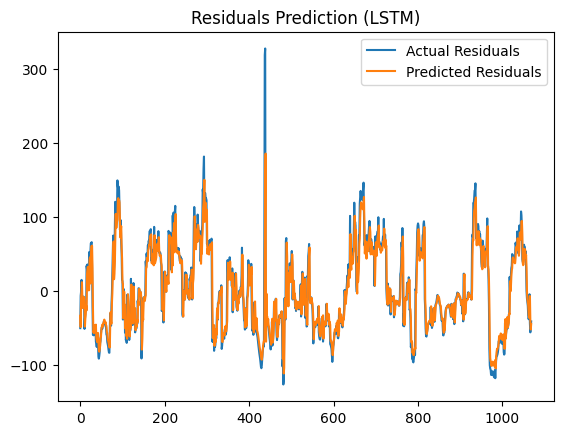

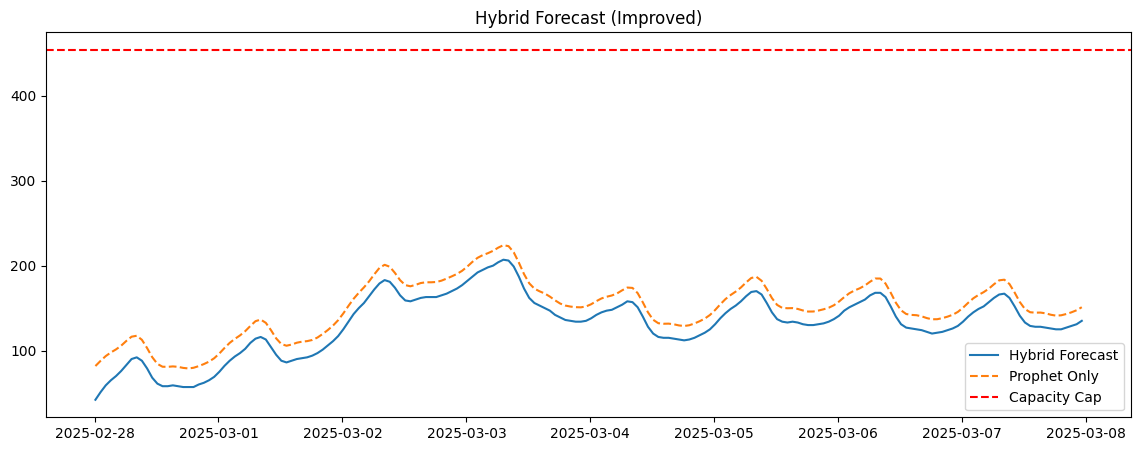

                 Date     Prophet  Residuals  Hybrid_Available
0 2025-02-28 00:10:01   81.744804 -38.914547                42
1 2025-02-28 01:10:01   87.876611 -36.543343                51
2 2025-02-28 02:10:01   93.489093 -34.387489                59
3 2025-02-28 03:10:01   97.773094 -32.376282                65
4 2025-02-28 04:10:01  101.397891 -30.545055                70


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ================================================
# ✅ Improved Hybrid Forecast: Prophet (with cap) + LSTM Residuals (Rolling)
# ================================================
!pip install pandas numpy scikit-learn tensorflow matplotlib prophet --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

# ================================================
# 1. Upload CSV & prepare data
# ================================================
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df_prophet = df[['Date', 'Available']].rename(columns={'Date': 'ds', 'Available': 'y'})

# ✅ Add capacity cap
cap_value = df['Available'].max() * 1.1
df_prophet['cap'] = cap_value

# ================================================
# 2. Fit Prophet with improved flexibility
# ================================================
model = Prophet(
    growth='logistic',
    daily_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.5,    # more flexible trend
    seasonality_prior_scale=10.0    # more flexible seasonality
)
model.fit(df_prophet)

# Make future dataframe
horizon = 192  # adjust if needed
future = model.make_future_dataframe(periods=horizon, freq='H')
future['cap'] = cap_value

forecast = model.predict(future)

# Visualize Prophet
model.plot(forecast)
plt.title(f'Prophet Forecast with cap={cap_value:.2f}')
plt.show()

# ================================================
# 3. Compute residuals
# ================================================
df_merged = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds')
df_merged['residual'] = df_merged['y'] - df_merged['yhat']

plt.figure(figsize=(12,5))
plt.plot(df_merged['ds'], df_merged['residual'])
plt.title('Residuals after Prophet')
plt.show()

# ================================================
# 4. Prepare residuals for LSTM with StandardScaler
# ================================================
residuals = df_merged[['ds', 'residual']].dropna().set_index('ds')
residuals_hourly = residuals.resample('1H').mean().interpolate()

scaler = StandardScaler()
scaled = scaler.fit_transform(residuals_hourly)

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 48
X, y = create_sequences(scaled, window_size)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ================================================
# 5. Train LSTM on residuals
# ================================================
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate residual model
y_pred_test = model_lstm.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred_test).flatten()

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'Residuals MAE: {mae:.2f} | RMSE: {rmse:.2f}')

plt.plot(y_test_inv, label='Actual Residuals')
plt.plot(y_pred_inv, label='Predicted Residuals')
plt.legend()
plt.title('Residuals Prediction (LSTM)')
plt.show()

# ================================================
# 6. Forecast residuals ahead (Rolling)
# ================================================
last_seq = scaled[-window_size:]
recursive_preds = []

for step in range(horizon):
    input_seq = last_seq[-window_size:].reshape(1, window_size, 1)
    pred = model_lstm.predict(input_seq, verbose=0)[0][0]
    recursive_preds.append(pred)
    last_seq = np.append(last_seq, [[pred]], axis=0)

residual_forecast = scaler.inverse_transform(np.array(recursive_preds).reshape(-1, 1)).flatten()

# ================================================
# 7. Combine Prophet + Residuals => Hybrid Forecast
# ================================================
prophet_forecast = forecast[-horizon:]['yhat'].values
hybrid_forecast = prophet_forecast + residual_forecast

# Clip to capacity limit
hybrid_forecast = np.clip(hybrid_forecast, 0, cap_value)

forecast_index = forecast[-horizon:]['ds'].values
final_df = pd.DataFrame({
    'Date': forecast_index,
    'Prophet': prophet_forecast,
    'Residuals': residual_forecast,
    'Hybrid_Available': hybrid_forecast.astype(int)
})

# ================================================
# 8. Visualize & Save
# ================================================
plt.figure(figsize=(14,5))
plt.plot(final_df['Date'], final_df['Hybrid_Available'], label='Hybrid Forecast')
plt.plot(final_df['Date'], final_df['Prophet'], label='Prophet Only', linestyle='--')
plt.axhline(cap_value, color='red', linestyle='--', label='Capacity Cap')
plt.legend()
plt.title('Hybrid Forecast (Improved)')
plt.show()

print(final_df.head())

final_df.to_csv("hybrid_forecast_capped_recursive_improved.csv", index=False)
files.download("hybrid_forecast_capped_recursive_improved.csv")

# ================================================
# 9. ✅ Optional: Compare with Actuals if you have them
# ================================================
# Uncomment below if you want to check accuracy directly:
# uploaded_actual = files.upload()
# actual_df = pd.read_csv(next(iter(uploaded_actual)))
# actual_df['Date'] = pd.to_datetime(actual_df['Date'])
# merged_df = pd.merge(actual_df, final_df, on='Date', how='inner')
#
# plt.figure(figsize=(14,5))
# plt.plot(merged_df['Date'], merged_df['Available'], label='Actual')
# plt.plot(merged_df['Date'], merged_df['Hybrid_Available'], label='Hybrid Forecast')
# plt.legend()
# plt.title('Actual vs Hybrid Forecast (Improved)')
# plt.show()
#
# print('MAE:', mean_absolute_error(merged_df['Available'], merged_df['Hybrid_Available']))
# print('RMSE:', np.sqrt(mean_squared_error(merged_df['Available'], merged_df['Hybrid_Available'])))


📂 Please upload your ODS file (check.ods or cleaned version)...


Saving check.ods to check (2).ods

📂 Please upload your CSV file (hybrid_forecast_capped_recursive_improved.csv or cleaned version)...


Saving hybrid_forecast_capped_recursive_improved.csv to hybrid_forecast_capped_recursive_improved (1).csv

✅ ODS File: check (2).ods
✅ CSV File: hybrid_forecast_capped_recursive_improved (1).csv
✅ Loaded CSV with encoding='utf-8' and delimiter=','

📝 ODS Columns: ['Date', 'Total Nodes(C)', 'In Use', 'Offline', 'Available']
📝 CSV Columns: ['Date', 'Prophet', 'Residuals', 'Hybrid_Available']


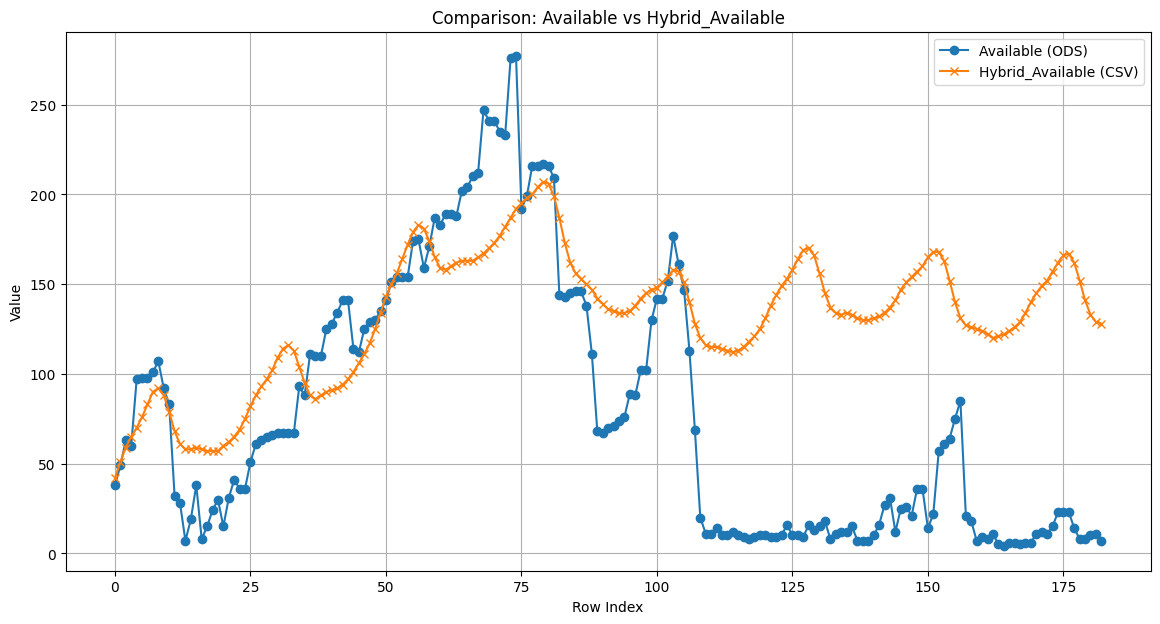

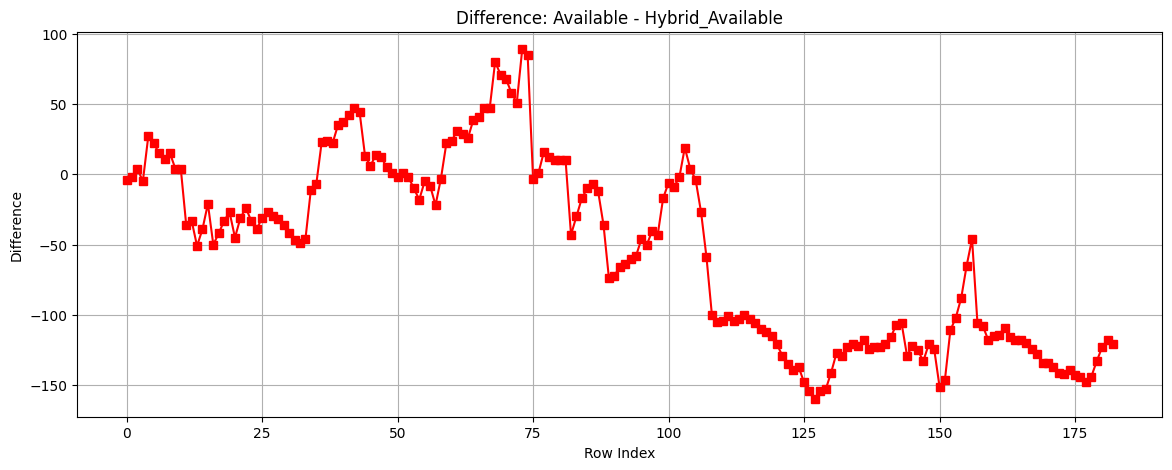


📊 First few differences:
0    -4
1    -2
2     4
3    -5
4    27
dtype: int64

✅ Comparison saved as 'available_comparison.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
# 📊 Compare 'Available' vs 'Hybrid_Available'
# ============================================

# STEP 1: Install required libraries
!pip install pandas odfpy matplotlib --quiet

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# STEP 3: Upload files
print("📂 Please upload your ODS file (check.ods or cleaned version)...")
uploaded1 = files.upload()

print("\n📂 Please upload your CSV file (hybrid_forecast_capped_recursive_improved.csv or cleaned version)...")
uploaded2 = files.upload()

# Get uploaded file names
ods_file = list(uploaded1.keys())[0]
csv_file = list(uploaded2.keys())[0]

print(f"\n✅ ODS File: {ods_file}")
print(f"✅ CSV File: {csv_file}")

# STEP 4: Load ODS
ods_df = pd.read_excel(ods_file, engine='odf') if ods_file.endswith('.ods') else pd.read_csv(ods_file)

# STEP 5: Load CSV with fallback
def load_csv(filename):
  for enc in ['utf-8', 'cp1252', 'ISO-8859-1']:
    for delim in [',', ';', '\t']:
      try:
        df = pd.read_csv(filename, encoding=enc, delimiter=delim, on_bad_lines='skip')
        print(f"✅ Loaded CSV with encoding='{enc}' and delimiter='{delim}'")
        return df
      except Exception:
        continue
  raise ValueError(f"❌ Could not load {filename}.")

csv_df = load_csv(csv_file)

# STEP 6: Clean columns
ods_df.columns = ods_df.columns.str.strip()
csv_df.columns = csv_df.columns.str.strip()

print("\n📝 ODS Columns:", list(ods_df.columns))
print("📝 CSV Columns:", list(csv_df.columns))

# STEP 7: Correct columns
ods_column = 'Available'
csv_column = 'Hybrid_Available' if 'Hybrid_Available' in csv_df.columns else 'Available'

# STEP 8: Extract & ensure numeric
available_ods = ods_df[ods_column].apply(pd.to_numeric, errors='coerce').dropna().reset_index(drop=True)
available_csv = csv_df[csv_column].apply(pd.to_numeric, errors='coerce').dropna().reset_index(drop=True)

# STEP 9: Align length
min_len = min(len(available_ods), len(available_csv))
available_ods = available_ods[:min_len]
available_csv = available_csv[:min_len]
difference = available_ods - available_csv

# STEP 10: Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(available_ods, label=f'{ods_column} (ODS)', marker='o')
plt.plot(available_csv, label=f'{csv_column} (CSV)', marker='x')
plt.title(f"Comparison: {ods_column} vs {csv_column}")
plt.xlabel("Row Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot difference
plt.figure(figsize=(14, 5))
plt.plot(difference, color='red', marker='s')
plt.title(f"Difference: {ods_column} - {csv_column}")
plt.xlabel("Row Index")
plt.ylabel("Difference")
plt.grid(True)
plt.show()

print("\n📊 First few differences:")
print(difference.head())

# STEP 11: Save results
comparison_df = pd.DataFrame({
    'ODS_Available': available_ods,
    'CSV_Hybrid_Available': available_csv,
    'Difference': difference
})
comparison_df.to_csv('available_comparison.csv', index=False)
print("\n✅ Comparison saved as 'available_comparison.csv'.")

# Optional: Download result
files.download('available_comparison.csv')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
📂 Please upload your ODS file (check.ods or cleaned version)...


Saving check.ods to check.ods

📂 Please upload your CSV file (hybrid_forecast_capped_recursive_improved.csv or cleaned version)...


Saving hybrid_forecast_final.csv to hybrid_forecast_final.csv

✅ ODS File: check.ods
✅ CSV File: hybrid_forecast_final.csv
✅ Loaded CSV with encoding='utf-8' and delimiter=','

📝 ODS Columns: ['Date', 'Total Nodes(C)', 'In Use', 'Offline', 'Available']
📝 CSV Columns: ['Date', 'Prophet', 'Residuals', 'Hybrid_Available']


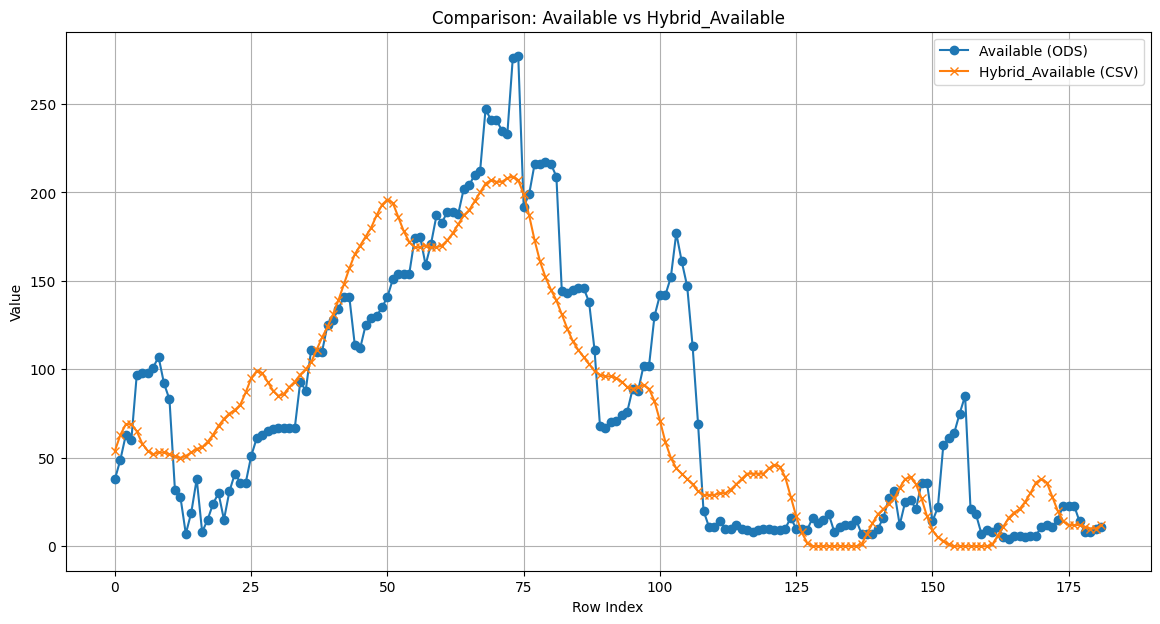

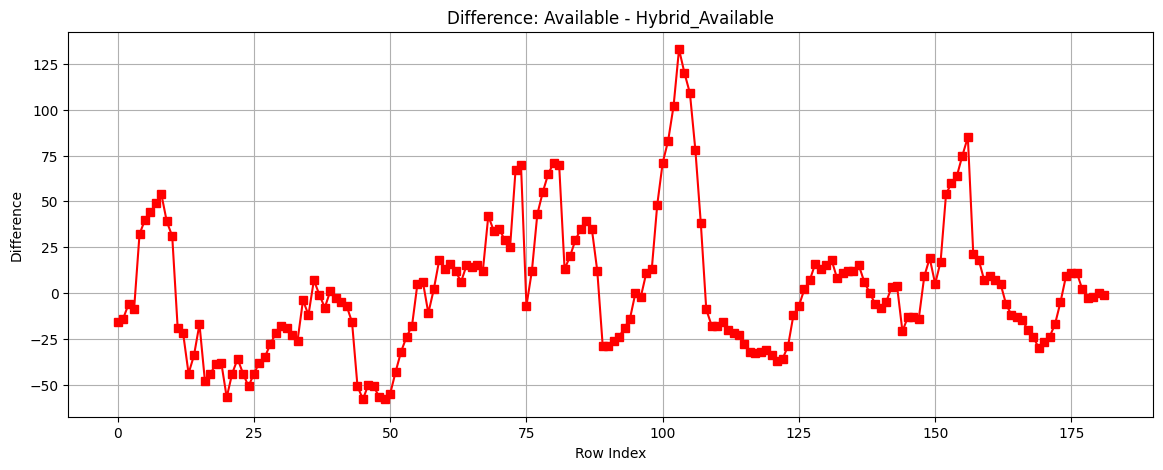


📊 First few differences:
0   -16
1   -14
2    -6
3    -9
4    32
dtype: int64

✅ Comparison saved as 'available_comparison.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
#Compare 'Available' vs 'Hybrid_Available'
# ============================================

# STEP 1: Install required libraries
!pip install pandas odfpy matplotlib --quiet

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# STEP 3: Upload files
print("📂 Please upload your ODS file (check.ods or cleaned version)...")
uploaded1 = files.upload()

print("\n📂 Please upload your CSV file (hybrid_forecast_capped_recursive_improved.csv or cleaned version)...")
uploaded2 = files.upload()

# Get uploaded file names
ods_file = list(uploaded1.keys())[0]
csv_file = list(uploaded2.keys())[0]

print(f"\n✅ ODS File: {ods_file}")
print(f"✅ CSV File: {csv_file}")

# STEP 4: Load ODS
ods_df = pd.read_excel(ods_file, engine='odf') if ods_file.endswith('.ods') else pd.read_csv(ods_file)

# STEP 5: Load CSV with fallback
def load_csv(filename):
  for enc in ['utf-8', 'cp1252', 'ISO-8859-1']:
    for delim in [',', ';', '\t']:
      try:
        df = pd.read_csv(filename, encoding=enc, delimiter=delim, on_bad_lines='skip')
        print(f"✅ Loaded CSV with encoding='{enc}' and delimiter='{delim}'")
        return df
      except Exception:
        continue
  raise ValueError(f"❌ Could not load {filename}.")

csv_df = load_csv(csv_file)

# STEP 6: Clean columns
ods_df.columns = ods_df.columns.str.strip()
csv_df.columns = csv_df.columns.str.strip()

print("\n📝 ODS Columns:", list(ods_df.columns))
print("📝 CSV Columns:", list(csv_df.columns))

# STEP 7: Correct columns
ods_column = 'Available'
csv_column = 'Hybrid_Available' if 'Hybrid_Available' in csv_df.columns else 'Available'

# STEP 8: Extract & ensure numeric
available_ods = ods_df[ods_column].apply(pd.to_numeric, errors='coerce').dropna().reset_index(drop=True)
available_csv = csv_df[csv_column].apply(pd.to_numeric, errors='coerce').dropna().reset_index(drop=True)

# STEP 9: Align length
min_len = min(len(available_ods), len(available_csv))
available_ods = available_ods[:min_len]
available_csv = available_csv[:min_len]
difference = available_ods - available_csv

# STEP 10: Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(available_ods, label=f'{ods_column} (ODS)', marker='o')
plt.plot(available_csv, label=f'{csv_column} (CSV)', marker='x')
plt.title(f"Comparison: {ods_column} vs {csv_column}")
plt.xlabel("Row Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot difference
plt.figure(figsize=(14, 5))
plt.plot(difference, color='red', marker='s')
plt.title(f"Difference: {ods_column} - {csv_column}")
plt.xlabel("Row Index")
plt.ylabel("Difference")
plt.grid(True)
plt.show()

print("\n📊 First few differences:")
print(difference.head())

# STEP 11: Save results
comparison_df = pd.DataFrame({
    'ODS_Available': available_ods,
    'CSV_Hybrid_Available': available_csv,
    'Difference': difference
})
comparison_df.to_csv('available_comparison.csv', index=False)
print("\n✅ Comparison saved as 'available_comparison.csv'.")

# Optional: Download result
files.download('available_comparison.csv')
